In [1]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
%matplotlib inline

In [2]:
dataset = ImageFolder(root='/content/drive/MyDrive/csc420_a2/task5')

In [3]:
labels = []

for n in dataset.classes:
    labels.append(n)

print(labels)

['DBI', 'SDD']


In [4]:
random_seed = 45
torch.manual_seed(random_seed);

test_pct = 0.4
count = len(dataset)
#print(count)
test_size = int(count*test_pct)
train_size = count - test_size


train_size, test_size

(1128, 751)

In [5]:
train_ds, test_ds = random_split(dataset, [train_size, test_size])
len(train_ds), len(test_ds)

(1128, 751)

DBI
<class 'PIL.Image.Image'>


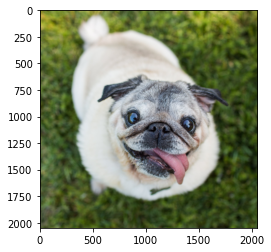

In [6]:
img, label = train_ds[6]
print(dataset.classes[label])
plt.imshow(img)
print(type(img))

In [7]:
class DogBreedDataset(Dataset):
    
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)  
            return img, label

In [8]:

imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
#    transforms.Resize((224, 224)),
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
    
])


test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

In [9]:
train_dataset = DogBreedDataset(train_ds, train_transform)
test_dataset = DogBreedDataset(test_ds, test_transform)
DBIdataset = DogBreedDataset(dataset, test_transform)

0


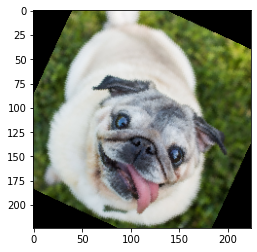

In [10]:
img, label = train_dataset[6]
print(label)
plt.imshow(img.permute(1,2,0))

In [11]:
batch_size =64

# Create DataLoaders
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)
DBI_dl = DataLoader(DBIdataset, batch_size*2, num_workers=2, pin_memory=True)

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


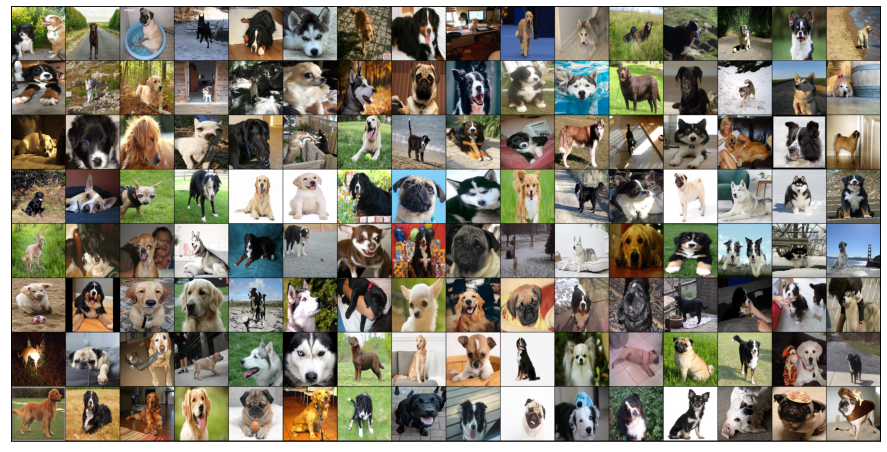

In [37]:
def show_batch(dl):
    for img, lb in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img.cpu(), nrow=16).permute(1,2,0))
        break
show_batch(test_dl)

# Set up Network



In [12]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [13]:
class ImageClassificationBase(nn.Module):
    # training step
    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        return loss
    
    # validation step
    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        acc = accuracy(out, targets)
        return {'val_acc':acc.detach(), 'val_loss':loss.detach()}
    
    # validation epoch end
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
        
    # print result end epoch
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"], result["val_loss"], result["val_acc"]))

In [14]:
class DogBreedResnet18Pretrained(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 7),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [15]:
resnet18_pretrained_model = DogBreedResnet18Pretrained()
resnet18_pretrained_model

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

DogBreedResnet18Pretrained(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [16]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)

In [17]:
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

In [18]:
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
DBI_dl = DeviceDataLoader(DBI_dl, device)
resnet18_pretrained_model = to_device(resnet18_pretrained_model, device);

cpu


In [19]:
from tqdm.notebook import tqdm

In [20]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        

def fit_one_cycle(epochs, max_lr, model, train_loader, test_loader, weight_decay=0, grad_clip=None, opt_func = torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    # set up one cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        
        # Training phase
        model.train()       
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            
            # calculates gradients
            loss.backward()
            
            # check gradient clipping 
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            # perform gradient descent and modifies the weights
            optimizer.step()
            
            # reset the gradients
            optimizer.zero_grad()
            
            # record and update lr
            lrs.append(get_lr(optimizer))
            
            # modifies the lr value
            sched.step()
            
        # Validation phase
        result = evaluate(model, test_loader, train_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
        
    return history
        
    

@torch.no_grad()
def evaluate(model, test_loader, train_loader):
    # I added train accuracy here
    model.eval()
    train_outputs = [model.validation_step(batch) for batch in train_loader]
    test_outputs = [model.validation_step(batch) for batch in test_loader]

    output_train = model.validation_epoch_end(train_outputs)
    output_test = model.validation_epoch_end(test_outputs)
    output = output_train
    output['test_acc'] = output_test['val_acc']
    return output

In [21]:
num_epochs = 10
opt_func = torch.optim.SGD

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

In [48]:
evaluate(resnet18_pretrained_model, train_dl, test_dl)

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


{'val_loss': 2.361128568649292,
 'val_acc': 0.12278293818235397,
 'test_acc': 0.03315972164273262}

In [22]:
history_resnet18_pretrained_model = fit_one_cycle(num_epochs, max_lr, resnet18_pretrained_model, train_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [0] : train_loss: 1.2198, val_loss: 0.5072, val_acc: 0.7189


  0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [1] : train_loss: 0.4212, val_loss: 0.3438, val_acc: 0.8474


  0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [2] : train_loss: 0.3042, val_loss: 0.2555, val_acc: 0.8858


  0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [3] : train_loss: 0.3037, val_loss: 0.6873, val_acc: 0.6977


  0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [4] : train_loss: 0.1976, val_loss: 0.3125, val_acc: 0.8714


  0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [5] : train_loss: 0.1535, val_loss: 0.2018, val_acc: 0.9076


  0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [6] : train_loss: 0.1289, val_loss: 0.1720, val_acc: 0.9323


  0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [7] : train_loss: 0.1151, val_loss: 0.2160, val_acc: 0.8970


  0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [8] : train_loss: 0.0785, val_loss: 0.0617, val_acc: 0.9825


  0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [9] : train_loss: 0.0691, val_loss: 0.0507, val_acc: 0.9896


In [23]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# Set the model to evaluation mode
def scores(model, test_dl):
  """
  """
  model.eval()

# Initialize empty lists to store predictions and true labels
  y_pred = []
  y_true = []

  # Iterate over batches in the test dataloader
  for images, labels in test_dl:
      # Move images and labels to device (GPU/CPU)
      images = images.to(device)
      labels = labels.to(device)
      
      # Disable gradient computation to speed up inference
      with torch.no_grad():
          # Make predictions
          outputs = model(images)
          # Get predicted labels for each image in the batch
          _, predicted = torch.max(outputs.data, 1)
      
      # Append predicted and true labels to their respective lists
      y_pred.extend(predicted.cpu().numpy())
      y_true.extend(labels.cpu().numpy())

  # Print classification report and accuracy score
  print(classification_report(y_true, y_pred))
  print("Accuracy:", accuracy_score(y_true, y_pred))
  return accuracy_score(y_true, y_pred)

In [40]:
accuracy_dbi_resnet13 = scores(resnet18_pretrained_model, test_dl)
print("Accuracy of Resnet18 on dataset classification :", accuracy_dbi_resnet13)

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


              precision    recall  f1-score   support

           0       0.83      0.72      0.77       255
           1       0.86      0.92      0.89       496

    accuracy                           0.85       751
   macro avg       0.85      0.82      0.83       751
weighted avg       0.85      0.85      0.85       751

Accuracy: 0.8535286284953395
Accuracy of Resnet18 on dataset classification : 0.8535286284953395


In [24]:
weights_fname = '/content/drive/MyDrive/csc420_a2/new_resnet18_pretained_model.pth'
torch.save(resnet18_pretrained_model.state_dict(), weights_fname)
torch.save(history_resnet18_pretrained_model, '/content/drive/MyDrive/csc420_a2/new_resnet18_training_history.pth')

In [25]:
history_resnet18_pretrained_model[0].keys()

dict_keys(['val_loss', 'val_acc', 'test_acc', 'train_loss', 'lrs'])

In [38]:
test_acc = []
train_acc = []
count = len(history_resnet18_pretrained_model)
time = list(range(count))

for h in history_resnet18_pretrained_model:
    train_acc.append(h['val_acc'])
    test_acc.append(h['test_acc'])


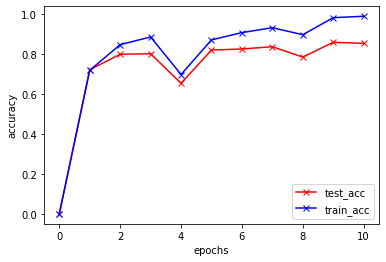

In [43]:
plt.plot(time, test_acc, c='red', label='test_acc', marker='x')
plt.plot(time, train_acc, c='blue', label='train_acc', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/csc420_a2/Figure 14.png', dpi=100)
plt.show()